In [6]:
#  Lab 4
!pip install kagglehub --quiet

import numpy as np, pandas as pd, matplotlib.pyplot as plt
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import average_precision_score, f1_score, recall_score

# Load data
import kagglehub
p = kagglehub.dataset_download("fedesoriano/company-bankruptcy-prediction")
df = pd.read_csv(Path(p)/"data.csv")
TARGET = "Bankrupt?"   # this column exists in this dataset
df = df.dropna(subset=[TARGET]).copy()
df[TARGET] = pd.to_numeric(df[TARGET], errors="coerce")
df = df.dropna(subset=[TARGET])
df.info()




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6819 entries, 0 to 6818
Data columns (total 96 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   Bankrupt?                                                 6819 non-null   int64  
 1    ROA(C) before interest and depreciation before interest  6819 non-null   float64
 2    ROA(A) before interest and % after tax                   6819 non-null   float64
 3    ROA(B) before interest and depreciation after tax        6819 non-null   float64
 4    Operating Gross Margin                                   6819 non-null   float64
 5    Realized Sales Gross Margin                              6819 non-null   float64
 6    Operating Profit Rate                                    6819 non-null   float64
 7    Pre-tax net Interest Rate                                6819 non-null   float64
 8    After-tax net Int

In [2]:
# Stratified split
train_df, test_df = train_test_split(df, test_size=0.30, random_state=42, stratify=df[TARGET])

# PSI (Population Stability Index)
def psi(a, b, buckets=10):
    a = np.asarray(a, float); b = np.asarray(b, float)
    a = a[~np.isnan(a)]; b = b[~np.isnan(b)]
    qs = np.unique(np.quantile(a, np.linspace(0,1,buckets+1)))
    if len(qs) < 3: return np.nan
    Ea,_ = np.histogram(a, qs); Eb,_ = np.histogram(b, qs)
    pa = np.clip(Ea/len(a), 1e-6, None); pb = np.clip(Eb/len(b), 1e-6, None)
    return float(np.sum((pa-pb)*np.log(pa/pb)))

numcols = train_df.select_dtypes(include=[np.number]).columns
numcols = [c for c in numcols if c != TARGET]
psi_table = pd.DataFrame(
    [{"feature":c, "psi": psi(train_df[c].values, test_df[c].values)} for c in numcols]
).sort_values("psi", ascending=False, na_position="last")
print("Top PSI features (train vs test):"); display(psi_table.head(10))
print("\nPSI guide: <0.10 stable, 0.10–0.20 monitor, >0.20 investigate")



Top PSI features (train vs test):


,feature,psi
12,Cash flow rate,0.016115
75,Fixed Assets to Assets,0.015788
61,Inventory/Working Capital,0.014977
51,Operating profit per person,0.013332
38,Long-term fund suitability ratio (A),0.012753
17,Net Value Per Share (C),0.010646
44,Total Asset Turnover,0.010356
16,Net Value Per Share (A),0.010332
31,Cash Reinvestment %,0.010292
53,Working Capital to Total Assets,0.009909



PSI guide: <0.10 stable, 0.10–0.20 monitor, >0.20 investigate


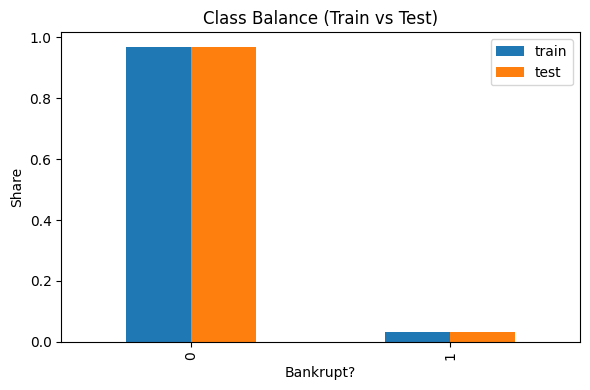

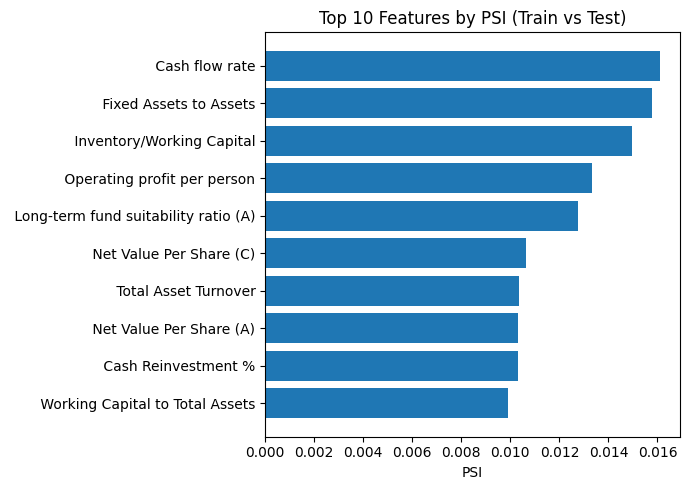

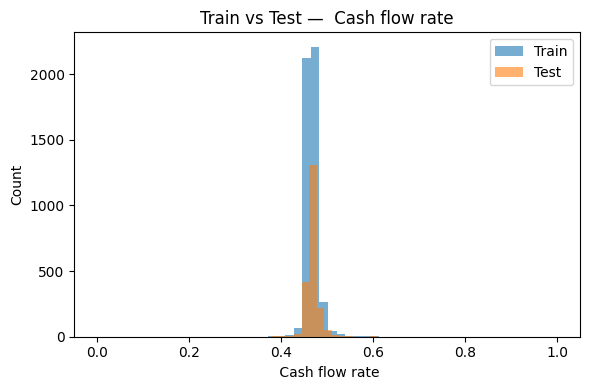

In [3]:
# Charts (take screenshots for report)
# Class balance
cb = pd.DataFrame({
    "train": train_df[TARGET].value_counts(normalize=True),
    "test":  test_df[TARGET].value_counts(normalize=True)
}).sort_index()
cb.plot(kind="bar", figsize=(6,4)); plt.ylabel("Share"); plt.title("Class Balance (Train vs Test)"); plt.tight_layout(); plt.show()

# PSI bar (top 10)
top = psi_table.head(10).dropna()
plt.figure(figsize=(7,5)); plt.barh(top["feature"][::-1], top["psi"][::-1])
plt.xlabel("PSI"); plt.title("Top 10 Features by PSI (Train vs Test)")
plt.tight_layout(); plt.show()

# Histogram for most-drifted feature
if top.shape[0]:
    f = top.iloc[0]["feature"]
    plt.figure(figsize=(6,4))
    plt.hist(train_df[f].dropna(), bins=40, alpha=0.6, label="Train")
    plt.hist(test_df[f].dropna(),  bins=40, alpha=0.6, label="Test")
    plt.title(f"Train vs Test — {f}"); plt.xlabel(f); plt.ylabel("Count"); plt.legend(); plt.tight_layout(); plt.show()



In [4]:
# Minimal models: baseline + 2, minimal metrics (PR-AUC, F1, Recall)
X_train, y_train = train_df.drop(columns=[TARGET]), train_df[TARGET].astype(int)
X_test,  y_test  = test_df.drop(columns=[TARGET]),  test_df[TARGET].astype(int)

models = {
    "LogReg (baseline)": Pipeline([
        ("imp", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression(max_iter=1000, class_weight="balanced"))
    ]),
    "RandomForest": Pipeline([
        ("imp", SimpleImputer(strategy="median")),
        ("clf", RandomForestClassifier(n_estimators=400, random_state=42, n_jobs=-1, class_weight="balanced"))
    ]),
    "GradientBoosting": Pipeline([
        ("imp", SimpleImputer(strategy="median")),
        ("clf", GradientBoostingClassifier(random_state=42))
    ]),
}

rows=[]
for name, m in models.items():
    m.fit(X_train, y_train)
    proba = m.predict_proba(X_test)[:,1]
    pred  = (proba>=0.5).astype(int)
    rows.append({"model":name,
                 "PR-AUC": average_precision_score(y_test, proba),
                 "F1": f1_score(y_test, pred),
                 "Recall": recall_score(y_test, pred)})
scores = pd.DataFrame(rows).sort_values("PR-AUC", ascending=False).round(4)
print("\nPositive rate (baseline PR-AUC):", round(y_test.mean(),4))
display(scores)


Positive rate (baseline PR-AUC): 0.0323


,model,PR-AUC,F1,Recall
2,GradientBoosting,0.4194,0.3725,0.2879
1,RandomForest,0.4192,0.2651,0.1667
0,LogReg (baseline),0.2747,0.2693,0.7121
